In this notebook, we'll use tsfresh to generate new features for our dataset based on elevation profiles, and we'll also split our data into training and testing sets for the purpose of model building. Let's start by loading the dataframe we created in the previous notebook.

In [1]:
import pandas as pd

filename='../Data/hiking_ts.csv'
df=pd.read_csv(filename)
df.head()

,ID,Step,Elevation
0,1,0,0.00000
1,1,1,3.28084
2,1,2,6.56168
3,1,3,13.12336
4,1,4,22.96588


As you can see, the data is organized according to ID, step, and elevation. The ID value corresponds to the trail rank in the original dataset (1 to 100). Let's plot the elevation profiles of the top 2 ranked trails: Mount Yonah Trail and East Palisades Trail.

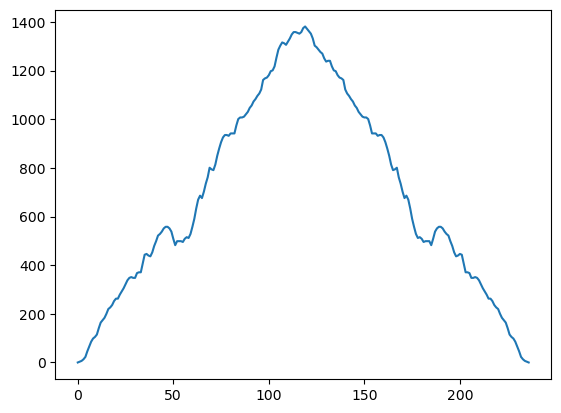

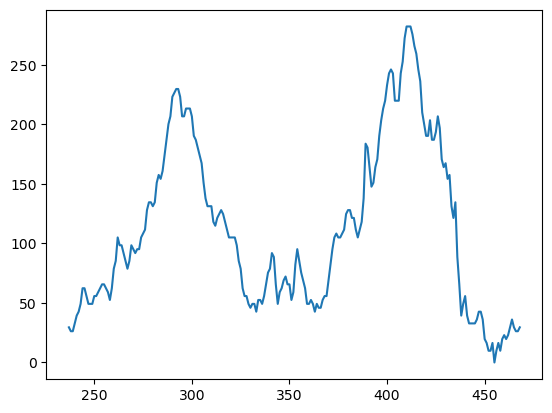

In [2]:
import matplotlib.pyplot as plt

df[df['ID'] == 1]['Elevation'].plot()
plt.show()

df[df['ID'] == 2]['Elevation'].plot()
plt.show()

The y axis captures the elevation in feet. Note that the values have been scaled such that each trail has a minimum value of 0. The x values simply represent the range of rows that the trail occupies within the overall dataframe. Let's also open our dataset with trail features and the max grade we computed in the previous notebook.

In [3]:
filename2='../Data/hiking2.csv'
df2=pd.read_csv(filename2)
df2.head()

,Length,Elevation gain,Rocky,Stairs,Muddy,Roots,Avg_grade,Difficulty,Max_grade
0,4.3,1489,1,0,0,0,0.065583,2.632911,0.437323
1,4.2,495,0,0,0,1,0.022321,1.831461,0.434012
2,4.7,705,1,1,0,0,0.028409,1.956522,0.465672
3,1.8,534,1,1,0,0,0.056187,2.109091,0.618551
4,3.5,508,1,0,0,0,0.027489,1.703833,0.371079


Now we are ready to use tsfresh to perform an analysis of our elevation profiles. I will be using the extract_relevant_features function, which consists of 3 steps:
1. Extract a comprehensive set of features from sequential data. More info on these features can be found [here](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html).
2. Impute any missing values
3. Perform feature filtering such that only features that have significance with respect to the target values are retained. More info on this process can be found [here](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html).

Let's extract the relevant features from our elevation profiles and see how many we wind up with.

In [4]:
from tsfresh import extract_relevant_features

y=df2['Difficulty']
y.index=range(1,len(y)+1) #re-indexing y to match ID column

if __name__ == '__main__':
    extracted_features = extract_relevant_features(df, y, column_id='ID', column_sort='Step')
    print(extracted_features.shape)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.19it/s]


(100, 184)


Voila! tsfresh has identified a whopping 184 features from are data that are relevant with respect to the target (i.e., trail difficulty). This number is really much higher than what we want since we only have a total of 100 points in our dataset, and our training dataset will be even smaller. To get around this problem, we'll use principal component analysis (PCA), which is a technique that performs a coordinate transformation such that axes are arranged in order of decreasing variance capture. In many cases, PCA allows for reducing a very large number of features into a much more manageable one. However, we need to separate our data into training and testing sets prior to performing PCA since we don't want the testing data to influence the PC scores of our training data. We'll go ahead and do that now, choosing a 70/30 train/test split.

In [5]:
import numpy as np

inds=np.arange(len(y))

np.random.seed(1)
np.random.shuffle(inds)

train_ratio=0.7
n_train=int(train_ratio*len(y))
inds_train=np.sort(inds[0:n_train])
inds_test=np.sort(inds[n_train:len(y)])

extracted_features_train=extracted_features.iloc[inds_train]
extracted_features_test=extracted_features.iloc[inds_test]

print(extracted_features_train.shape)
print(extracted_features_test.shape)

(70, 184)
(30, 184)


Having split the tsfresh-extracted features into training and testing sets, we are now ready to perform PCA. We'll fit our PCA object on the training data and then use it to transform both the training and testing data. We'll also look at the first 10 PC scores by percent of explained variance.

In [6]:
from sklearn.decomposition import PCA

my_pca=PCA()
pc_scores_train=my_pca.fit_transform(extracted_features_train)
pc_scores_test=my_pca.transform(extracted_features_test)
pct_var=my_pca.explained_variance_ratio_
cum_pct_var=np.cumsum(pct_var)

print(cum_pct_var[0:10])

[0.98660161 0.99998984 0.99999647 0.99999998 0.99999999 1.
 1.         1.         1.         1.        ]


As you can see, the first PC score accounts for a staggering 99.3% of the overall variance within the original 184 features. Now let's create a plot of the first two PC scores.

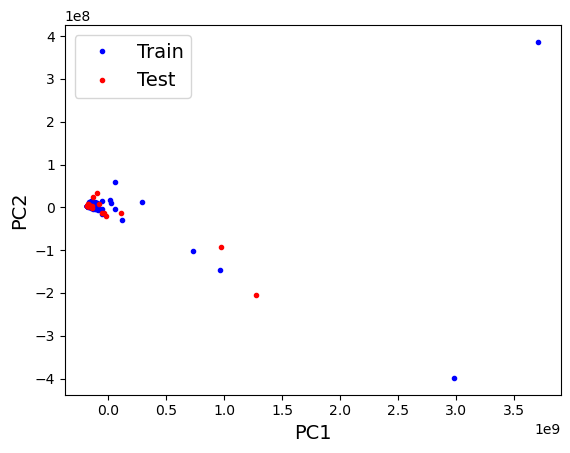

In [7]:
plt.figure()
plt.plot(pc_scores_train[:,0],pc_scores_train[:,1],'b.')
plt.plot(pc_scores_test[:,0],pc_scores_test[:,1],'r.')
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
plt.legend(['Train','Test'],fontsize=14)

Most of the data is clustered in a small region, with a few notable outliers present. In order to interpret the significance of PC scores, it is useful to map the points to their corresponding identities. I have done so with a few examples in the following figure:

<img src="../Images/pca_hiking.png" width="900" height="450" style="display: block; margin: auto; max-width: 100%;" />

Clearly, PC1 is capturing something significant: the outliers with high PC1 values are some of the most difficult hikes, and the largest outlier (3.77e9) corresponds to the most difficult hike in the entire dataset (Appalachian Approach Trail to Springer Mountain). It's very possible that there's some overlap between PC1 and other features already present in our dataset, but it also contains new information since it's based on complex statistics of elevation profiles. In any case, we definitely want to consider it when building our model. We'll also include PC2 and PC3 for additional certainty that we're getting all the most important information from the PCA dataset.

Now let's split our original dataset according to the same indices we used for the tsfresh features. We'll look at the first few rows of the training dataset for a sanity check.

In [8]:
df2_train=df2.iloc[inds_train]
df2_train.index=range(0,df2_train.shape[0])
df2_test=df2.iloc[inds_test]
df2_test.index=range(0,df2_test.shape[0])
df_pc_train=pd.DataFrame(pc_scores_train[:,0:3],columns=['PC1','PC2','PC3'])
df_pc_test=pd.DataFrame(pc_scores_test[:,0:3],columns=['PC1','PC2','PC3'])

df_train=pd.concat([df2_train,df_pc_train],axis=1)
df_test=pd.concat([df2_test,df_pc_test],axis=1)

df_train.head()

,Length,Elevation gain,Rocky,Stairs,Muddy,Roots,Avg_grade,Difficulty,Max_grade,PC1,PC2,PC3
0,4.3,1489,1,0,0,0,0.065583,2.632911,0.437323,9.677791e+08,-1.470110e+08,6.834277e+06
1,4.7,705,1,1,0,0,0.028409,1.956522,0.465672,-1.702746e+08,5.713342e+06,-6.630057e+04
2,1.8,534,1,1,0,0,0.056187,2.109091,0.618551,-1.493663e+08,3.723912e+06,-7.795148e+05
3,3.5,508,1,0,0,0,0.027489,1.703833,0.371079,-1.564175e+08,5.284983e+06,-5.060873e+05
4,3.5,380,0,0,0,1,0.020563,1.668342,0.244496,-1.713756e+08,4.753831e+06,-6.157738e+05


Looks good. Let's save our training and testing datasets as a final step.

In [9]:
df_train.to_csv('../Data/hiking_train.csv',index=False)
df_test.to_csv('../Data/hiking_test.csv',index=False)